In [ ]:
!conda install matplotlib scikit-learn pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch

In [27]:
import torch, torchvision
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPOCHS = 4
BATCH_SIZE = 200
LEARNING_RATE = 0.001

# Normalize to Tensor of normalize range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

train_dataset = torchvision.datasets.FashionMNIST(root="dataset", train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root="dataset", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

classes= ("T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot")

In [28]:
#  Examine a sample
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([200, 1, 28, 28])
torch.Size([200])


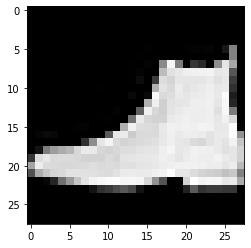

In [29]:
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap="Greys_r")

In [30]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Input: 1x28x28
        # 1 input channel, 6 output channels, kernel size of 5x5
        # Output: 6x24x24
        self.conv1 = nn.Conv2d(1, 6, 5)
        # Input: 6x24x24
        # Kernel size of 2x2
        # Output: 6x12x12
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv1_drop = nn.Dropout2d(0.2)
        # Input: 6x12x12
        # 6 input channel, 16 output channels, kernel size of 3x3
        # Output: 16x10x10
        self.conv2 = nn.Conv2d(6, 16, 3)
        # Input: 16x10x10
        # Kernel size of 2x2
        # Output: 16x5x5
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv2_drop = nn.Dropout2d(0.2)
        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)
        pass

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv1_drop(x)
        x = self.pool1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = self.pool2(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [31]:
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [32]:
import time, math
from sklearn.metrics import accuracy_score

start = time.time()
train_losses = []
test_losses = []

for epoch in range(EPOCHS):

    # Train mode
    model.train()

    for i, batch in enumerate(train_loader):
        # Send data to device
        inputs, labels = batch[0].to(device), batch[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + optimize
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            train_loss = criterion(outputs, labels)
            train_loss.backward()
            optimizer.step()

        # Setup batch statistics
        preds = torch.argmax(outputs, dim=1)
        correct = torch.sum(torch.eq(preds, labels)).item()
        elapsed = time.time() - start

        # Print training statistics
        if not i % (math.ceil(len(train_loader) / 4)):
                print(f'epoch: {epoch}, batch: {i:<{len(str(len(train_loader)))}}/{len(train_loader)}, time: {elapsed:.3f}s, loss: {train_loss.item():.3f}, acc: {correct / BATCH_SIZE:.3f}')
        
    train_losses.append(train_loss.item())

    # Evaluation mode
    model.eval()
    
    batch_acc = []

    for i, batch in enumerate(test_loader):
        # Send data to device
        inputs, labels = batch[0].to(device), batch[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds = preds.to(device).tolist()
            batch_acc.append(accuracy_score(preds, labels.tolist()))
            test_loss = criterion(outputs, labels.long())

    # Print test statistics
    print(f'Accuracy on the test set: {sum(batch_acc)/len(batch_acc):.3f}')

    test_losses.append(test_loss.item())

epoch: 0, batch: 0  /300, time: 0.050s, loss: 2.301, acc: 0.140
epoch: 0, batch: 75 /300, time: 2.887s, loss: 0.731, acc: 0.715
epoch: 0, batch: 150/300, time: 5.723s, loss: 0.645, acc: 0.725
epoch: 0, batch: 225/300, time: 8.889s, loss: 0.549, acc: 0.785
Accuracy on the test set: 0.803
epoch: 1, batch: 0  /300, time: 13.854s, loss: 0.658, acc: 0.790
epoch: 1, batch: 75 /300, time: 17.058s, loss: 0.431, acc: 0.845
epoch: 1, batch: 150/300, time: 20.234s, loss: 0.589, acc: 0.790
epoch: 1, batch: 225/300, time: 23.440s, loss: 0.472, acc: 0.815
Accuracy on the test set: 0.841
epoch: 2, batch: 0  /300, time: 28.492s, loss: 0.492, acc: 0.840
epoch: 2, batch: 75 /300, time: 31.693s, loss: 0.437, acc: 0.830
epoch: 2, batch: 150/300, time: 34.845s, loss: 0.397, acc: 0.840
epoch: 2, batch: 225/300, time: 37.591s, loss: 0.499, acc: 0.810
Accuracy on the test set: 0.857
epoch: 3, batch: 0  /300, time: 42.019s, loss: 0.501, acc: 0.855
epoch: 3, batch: 75 /300, time: 44.719s, loss: 0.491, acc: 0.83

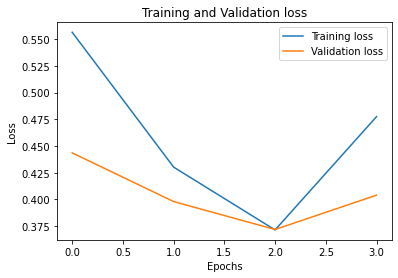

In [33]:
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()